In [1]:
import numpy as np
import matplotlib.pyplot as plt
from medpy import io
#from radiomics import featureextractor, imageoperations
import six
import os
import pandas as pd
import SimpleITK as sitk
#import seaborn as sns
#from sklearn.metrics import roc_auc_score
import math
from intensity_normalization.typing import Modality, TissueType
from intensity_normalization.normalize.fcm import FCMNormalize
import intensity_normalization.normalize.zscore as zscore



/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path = "/data1/practical-sose23/morphometric/data/"
seg_guer_path = "/data1/practical-sose23/morphometric/picai_labels/anatomical_delineations/whole_gland/AI/Guerbet23/"
seg_bosma_path = "/data1/practical-sose23/morphometric/picai_labels/anatomical_delineations/whole_gland/AI/Bosma22b/"

def get_image_and_segmentaion(patient_id, study_id):
    if not isinstance(patient_id, str):
        patient_id = str(patient_id)

    if not isinstance(study_id, str):
        study_id = str(study_id)
    
    image = None
    segmentation = None
    for file in os.listdir(data_path + patient_id + "/"):
        modality = "t2w"
        string = "{0}_{1}_{2}.mha".format(patient_id,study_id,modality)
        if string == file:
            if study_id in file:
                image = sitk.ReadImage(data_path + patient_id + "/" +  file, sitk.sitkFloat32)
                path_image = data_path + patient_id + "/" +  file

    for file in os.listdir(seg_guer_path):
        if patient_id+"_"+study_id + ".nii.gz" == file:
            
            segmentation = sitk.ReadImage(seg_guer_path + file, sitk.sitkUInt8)
            path_mask = seg_guer_path + file

    return (image, segmentation)

def plot_sitk(sitk_obj):

    pixel_array = sitk.GetArrayFromImage(sitk_obj)
    
    columns = 5
    rows = math.ceil(pixel_array.shape[0] / columns)

    fig = plt.figure(figsize=(20,rows*4))

    for i in range(pixel_array.shape[0]):
        #im = data[:,:,i]
        #mask = 
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(pixel_array[i], cmap="gray", interpolation="none")


def normalize(sitk_image):

    stat_filter = sitk.StatisticsImageFilter()
    stat_filter.Execute(sitk_image)

    min_intensity = stat_filter.GetMinimum()
    max_intensity = stat_filter.GetMaximum()

    # Normalize the intensity values using IntensityWindowing
    normalized_image = sitk.IntensityWindowing(sitk_image, min_intensity, max_intensity, 0, 1)
    return normalized_image

def normalize2(sitk_image):

    pixel_array = sitk.GetArrayFromImage(sitk_image)

    min_intensity = pixel_array.min()
    max_intensity = pixel_array.max()
    normalized_array = (pixel_array-min_intensity)/(max_intensity-min_intensity)
    # Convert the normalized numpy array to a sitk object
    normalized_image = sitk.GetImageFromArray(normalized_array)

    # Optionally, set the origin, spacing, and direction if necessary
    normalized_image.SetOrigin(sitk_image.GetOrigin())
    normalized_image.SetSpacing(sitk_image.GetSpacing())
    normalized_image.SetDirection(sitk_image.GetDirection())
    return normalized_image

In [3]:
image, mask = get_image_and_segmentaion(10000, 1000000)

image_norm = normalize(image)

In [4]:
gt = pd.read_csv("/data1/practical-sose23/morphometric/picai_labels/clinical_information/marksheet.csv")
gt.head()

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.7,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.7,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.2,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.0,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.0,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO


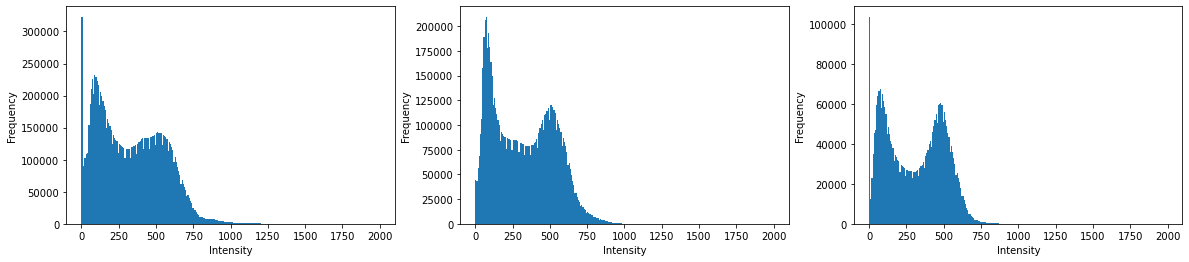

In [5]:
n_images = 3

columns = 3
rows = math.ceil(n_images / columns)

fig = plt.figure(figsize=(20,rows*4))


for index, row in gt.head(n_images).iterrows():
    
    

    image, mask = get_image_and_segmentaion(row["patient_id"], row["study_id"])
    np_image = sitk.GetArrayFromImage(image)

    # Flatten the numpy array to a 1D vector
    np_image = np_image.flatten()

    # Plot the histogram of intensities using matplotlib
    fig.add_subplot(rows, columns, index+1)
    plt.hist(np_image, bins=256, range=(0,2000))
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    #plt.title("Histogram of MRI scan")



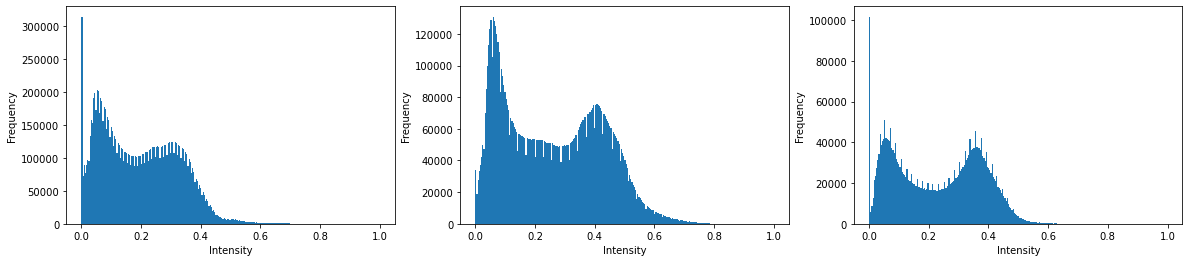

In [6]:
n_images = 3

columns = 3
rows = math.ceil(n_images / columns)

fig = plt.figure(figsize=(20,rows*4))


for index, row in gt.head(n_images).iterrows():
    
    

    image, mask = get_image_and_segmentaion(row["patient_id"], row["study_id"])
    image = normalize2(image)
    np_image = sitk.GetArrayFromImage(image)

    # Flatten the numpy array to a 1D vector
    np_image = np_image.flatten()

    # Plot the histogram of intensities using matplotlib
    fig.add_subplot(rows, columns, index+1)
    plt.hist(np_image, bins=256)
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    #plt.title("Histogram of MRI scan")

